In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


import os
import h5py

#https://github.com/lmcinnes/umap/issues/828
import umap.umap_ as umap
# import umap
import time
import numpy as np
from PIL import Image
from IPython.display import display as ipy_display, clear_output
import matplotlib.pyplot as plt

# parameters

In [2]:
num_classes = 5
batch_size = 8

dataset_name = 'abdomen'

suffix = "run4"

# CUDA

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# label_ids_abdomen

In [4]:
label_ids_abdomen = {"ignore": 0,
    "liver": 1,
    "right_kidney": 2,
    "left_kidney": 3,
    "spleen": 4,
}

label_ids = label_ids_abdomen

# sample_from_gaussians

In [5]:
means = np.load("./extras/means_" + dataset_name + "_" + suffix + ".npy")
covs = np.load("./extras/covs_" + dataset_name + "_" + suffix + ".npy")

In [6]:
means.shape

(5, 5)

In [7]:
covs.shape

(5, 5, 5)

In [8]:
def sample_from_gaussians(means, covs, n_samples):
    # Return samples from the num_classes gaussians trained on the source dataset
    # n_samples is an array of the same size as gmms, representing the number of samples to
    # be returned from each gaussian
    
    # class 0 is the class to be ignored
    # assert n_samples[0] == 0
    
    n = len(n_samples)
    
    res_x = []
    res_y = []
    
    for i in range(n):
        if n_samples[i] > 0:
            curr_x = np.random.multivariate_normal(means[i], covs[i], n_samples[i])
            curr_y = np.repeat(i, n_samples[i])
                        
            res_x.append(curr_x)
            res_y.append(curr_y.reshape(-1,1))

    res_x = np.vstack(res_x)
    res_y = np.vstack(res_y).ravel()
    
    perm = np.random.permutation(res_x.shape[0])
    
    return res_x[perm,:], res_y[perm]

In [9]:
n_samples = np.ones(num_classes, dtype=int)
n_samples *= 2000

In [10]:
xx, yy = sample_from_gaussians(means, covs, n_samples=n_samples)

In [11]:
NUM_COLORS = num_classes
reducer = umap.UMAP()
umap_embedding = reducer.fit_transform(xx)

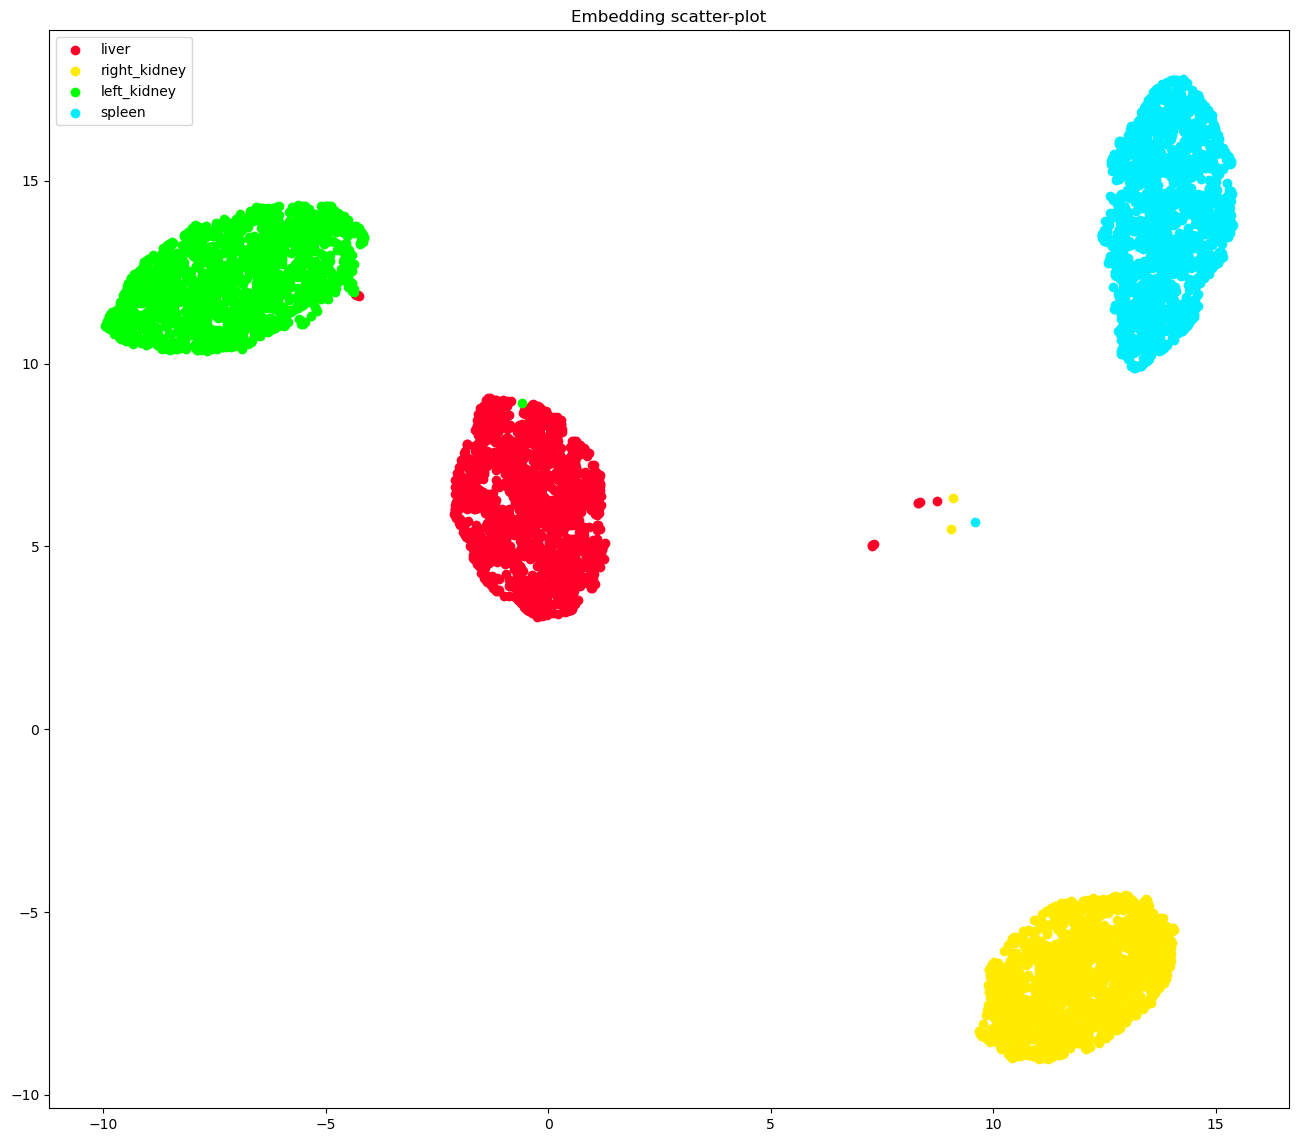

In [12]:
plt.figure(figsize=(16,14))
cm = plt.get_cmap('gist_rainbow')

shift = 1 / len(label_ids.keys())
idx = 0
for label in label_ids:
    if label == 'ignore':
        continue
    ind = yy == label_ids[label]
    
    plt.scatter(umap_embedding[:,0][ind], umap_embedding[:,1][ind], label=label, \
                color=cm(1.*idx/NUM_COLORS))
    idx += 1

plt.title("Embedding scatter-plot")
plt.legend()
    
plt.show()